# Reservoir operation modelling
In this Notebook we will see how we can simulate the operation of water supply reservoir system.

<left><img src="images/Dam1.gif" width = "800px"><left>
    
We consider a simple illustrative system where a reservoir is operated to supply water to a domestic consumption node, while ensuring a minimum environmental flow in the downstream river (also called “environmental compensation flow”) and maintaining the water level in the reservoir within prescribed limits. We use a mathematical model to link all the key variables that represent the reservoir dynamics (inflow, storage and outflows) and use model simulation/optimisation to determine the reservoir release scheduling that will best meet the water demand over a coming period of time, given the predicted (or assumed) scenario of future inflows.
    
<left> <img src="images/system_representation_IO0.png" width = "600px"><left>
    
## Import libraries
Before getting started, let's import some libraries that will be used throughout the Notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact # to create interactive elements and figures

## The reservoir model

The mathematical model of the reservoir essentially consists of a water balance equation, where the storage (***s***) at a future time step (for example, at the beginning of the next week) is predicted from the storage at the current time (the beginning of the this week) by adding and subtracting the inflows and outflows that will occur during the temporal interval ahead:

$s(t+1) = s(t) + inflow(t) – evap(t) – env(t) - spill(t) – supply(t)$   

Where

***s(t)*** = reservoir storage at time-step t, in Vol (for example: ML)

***inflow(t)*** = reservoir inflows in the interval [t,t+1], in Vol/time (for example: ML/week).

***evap(t)*** = evaporation from the reservoir surface area in the interval [t,t+1], in Vol/time (for example: ML/week).

***env(t)*** = environmental compensation flow in the interval [t,t+1], in Vol/time (for example: ML/week). 

***spill(t)*** = outflow through spillways (if any) in the interval [t,t+1], in Vol/time (for example: ML/week). 

***supply(t)*** = regulated reservoir release for water supply in the interval [t,t+1], in Vol/time (for example: ML/week). 

<left> <img src="images/system_representation_IO1.png" width = "600px"><left>
    
#### Implementation of the reservoir simulation function
Here we define a function that implements the reservoir simulation, that is, iteratively apply the mass balance equation and reconstruct the temporal evolution of the reservoir variables over the simulation period

In [2]:
def res_sim(inflow,evap,demand,s_0,s_max,env_min,supply):
    
    """
    This is a model that simulates the operation of a single reservoir system. 
    It essentially consists of a water balance equation, 
    where the storage (s) at a future time step is predicted from the storage at the current time 
    by adding and subtracting the inflows and outflows that will occur during the temporal interval ahead

    The inputs of the model are:

    inflow = time series of reservoir inflows [ML]
    evap = time series of evaporation from the reservoir surface area [ML]
    demand = time series of water demand [ML]
    s_0 = initial reservoir storage [ML]
    s_max = maximum storage capacity of the reservoir [ML]
    env_min = minimum environmental flow [ML]
    supply = regulated reservoir release for water supply [ML]
    
    And the outpus are:
    
    s = reservoir storage [ML]
    env = environmental compensation flow [ML]
    spill = outflow through spillways [ML]
    supply = regulated reservoir release for water supply [ML]
    
    """
    
    T = len(inflow) # number of time steps (weeks)
    # Declare output variables

    s = np.zeros(T+1) # reservoir storage in ML

    spill = np.zeros(T) # spillage in ML

    env = np.zeros(T) + env_min # environmental compensation flow
    
    # Initial storage
    s[0] = s_0

    for t in range(T): # Loop for each time-step (week)

        # If at week t the inflow (I) is lower than the minimum environmental compensation (env_min), 
        # then the environmental compensation (env) = inflow (I)  
        if env_min >= inflow[t] :
            env[t] = inflow[t]
        # If the minimum environmental compensation is higher than the water resource available (S + I - E)
        # then the environmental compensation is equal to the higher value between 0 and the resource available
        if env_min >= s[t] + inflow[t] - evap[t]:
            env[t] = max(0,s[t] + inflow[t] - evap[t]) 
        # If the demand is higher than the water resource available (S + I - E - env)
        # then the release for water supply is equal to the higher value between 0 and the resource available            
        if supply[t] >= s[t] + inflow[t] - evap[t] - env[t]:
            supply[t] = min(supply[t],max(0,s[t] + inflow[t] - evap[t] - env[t]))
        # The spillage is equal to the higher value between 0 and the resource available exceeding the reservoir capacity
        spill[t] = max(0,s[t] + inflow[t] - supply[t] - env[t] - evap[t] - s_max)
        # The final storage (initial storage in the next step) is equal to the storage + inflow - outflows
        s[t+1] = s[t] + inflow[t] - supply[t] - env[t]- evap[t] - spill[t]
        
    return s,env,spill,supply

#### Definition of inflow and demand scenarios
Let's assume we want to look at the next 8 weeks the number of weeks, and assume we have forecasts of inflows, evaporation and demand for this period.

In [3]:
inflow = np.array([15,17,19,11,9,4,3,8]) # (ML/week) time series of inflow forecasts
evap = np.array([1,1,2,2,2,2,2,3]) # (ML/week) time series of evaporation forecasts
demand = np.array([13,13,17,18,20,22,25,26]) # (ML/week) time series of demand forecasts
T = len(inflow) # number of time steps (weeks)
weeks = np.arange(1,T+1)

Plot the **inflow** forecast:

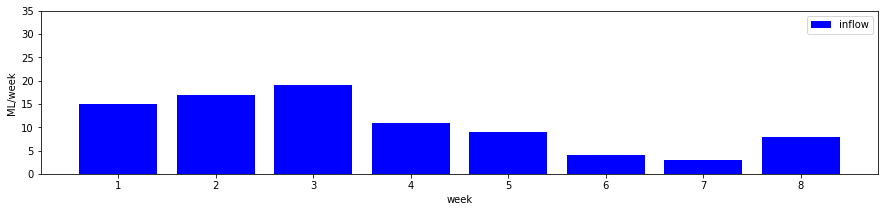

In [4]:
plt.figure(figsize=(15,3)) # to define the plot size
plt.bar(weeks,inflow, color = 'blue', label = 'inflow')
plt.xlabel('week')
plt.ylabel('ML/week')
plt.ylim([0,35])
plt.legend()

Plot the **demand** forecast:

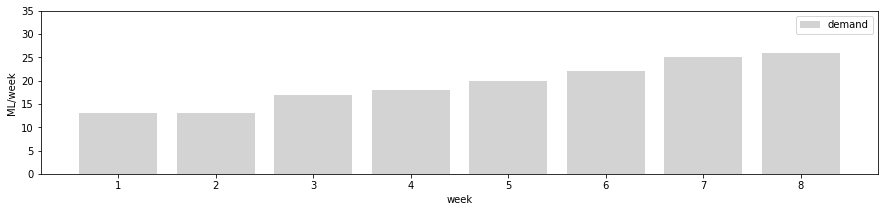

In [5]:
plt.figure(figsize=(15,3)) # to define the plot size
plt.bar(weeks,demand, color = 'lightgray', label = 'demand')
plt.xlabel('week')
plt.ylabel('ML/week')
plt.ylim([0,35])
plt.legend()

#### Definition of other input parameters
Let's define other variables that are needed for the reservoir system simulation, such as the reservoir storage capacity, the environmental compensation flow, etc.

In [6]:
### Constraints ###
s_max = 150 #  (ML) Maximum storage (=reservoir capacity)
s_min = 0 #  (ML) Minimum storage 
env_min = 2 # (ML/week)   # Environmental compensation flow

### Initial conditions ###
s_0 = 80 # (ML) # Storage volume at the beginning of the simulation period

Let's simulate our system using the provided input data and by changing the water supply each week try meet the water demand

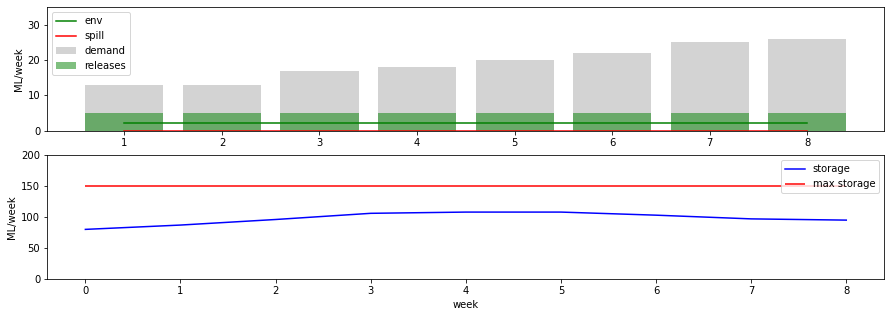

In [7]:
# We create an array with the weekly release volumes
supply = np.array([5, 5, 5, 5, 5, 5, 5, 5])
# We run the model


# Figure: supply vs demand
plt.figure(figsize=(15,5)) # to define the plot size
plt.subplot(2,1,1)



# Figure: reservoir storage
plt.subplot(2,1,2)




**Questions**: Can you meet the water demand every week? Why? How many times (weeks) the reservoir system fails?

## Determining the release scheduling by trial and error (manual optimisation)
Here we want to use the reservoir model to assist the reservoir operator in determining the best scheduling of regulated reservoir releases (`supply`) in response to a certain scenario of inflows. The goal is to increase the water supply security by optimizing the performance of the reservoir system. For this purpose we will that is, to minimise the objective function:

### How reliable is our system?
Or, how likely is that our system fails? To quantify this, let's create a function to calculate the **Reliability indicator** of the reservoir system and show its value in the figure so we can see how its value change as we modify the supply each week.

In [8]:
# In this cell we write the code of the reliability function
def reliability(supply, demand):
    
    
    

    return REL        

In [9]:
# In this cell we create a function that plots the supply vs demand figure and the reservoir storage plot.
def plots_fun(supply,demand,s,title):
    
    """
    This function plots the supply vs demand figure (as a bar plot) and the reservoir storage figure (as a line plot)
    The inputs of the function are the time series of supply, demand, storage and the title of the figure
    """
    
    
    
    
    

#### Determining the optimal release scheduling via interactive visualisation

Use the slider to set the release amount for each week in the simulation period, and in doing so try to minimise the Reliability indicator. 

In [10]:
# In this cell we write the code to create the interactive figure
@interact(rel_1=(0,35),rel_2=(0,35),rel_3=(0,35),rel_4=(0,35),rel_5=(0,35),rel_6=(0,35),rel_7=(0,35),rel_8=(0,35))
def int_res_operation_REL(rel_1=0,rel_2=0,rel_3=0,rel_4=0,rel_5=0,rel_6=0,rel_7=0,rel_8=0):
    
    """
    This function simulates the reservoir system and lets you change in an interactive way 
    the supply volume for each week of the study period. This function shows two figures,
    the supply vs demand figure for the study periods and the evolution of the reservoir storage.
    This function also shows the value of the Reliability indicator in the title of the figure
    """
    
    supply = np.array([rel_1,rel_2,rel_3,rel_4,rel_5,rel_6,rel_7,rel_8])
    
    # we run the function that simulates the reservoir system

    
    
    # we run the function to calculate the reliability indicator

    
    
    # Here we run the function to plot the figures

    
    

interactive(children=(IntSlider(value=0, description='rel_1', max=35), IntSlider(value=0, description='rel_2',…

### How vulnerable is our system?
To quantify how vulnerable is our system, let's create a function to calculate the **Vulnerability indicator** of the reservoir system and show its value in the figure so we can see how its value change as we modify the supply each week.

In [11]:
# In this cell we write the code of the reliability function
def vulnerability(supply, demand):

    
    
    
    
    return VUL

#### Determining the optimal release scheduling via interactive visualisation

Use the slider to set the release amount for each week in the simulation period, and in doing so try to minimise the Vulnerability indicator. 

In [12]:
# In this cell we write the code to create the interactive figure




interactive(children=(IntSlider(value=0, description='rel_1', max=35), IntSlider(value=0, description='rel_2',…

### How resilient is our system?
To quantify how resilient is our system, let's create a function to calculate the **Resiliency indicator** of the reservoir system and show its value in the figure so we can see how its value change as we modify the supply each week.

In [13]:
# In this cell we write the code of the reliability function
def resiliency(supply, demand):

    
    
    
    
    
    return RES

#### Determining the optimal release scheduling via interactive visualisation

Use the slider to set the release amount for each week in the simulation period, and in doing so try to minimise the Resiliency indicator. 

In [14]:
# In this cell we write the code to create the interactive figure







interactive(children=(IntSlider(value=0, description='rel_1', max=35), IntSlider(value=0, description='rel_2',…

### Another way to calculate the vulnerability of our system: squared deficit
The goal is to minimise the deficit with respect to a prescribed water demand, that is, to minimise this objective function:

$$SD = 1/T \sum_{t=1}^{T} [ \ max( \ 0, \ demand(t)-supply(t) \ ) \ ]^2 $$

where `T` is the length of the simulation period that we are considering, and `demand` is the water demand for each time-interval in that period, and `SD` stands for **Squared Deficit**. Notice that the function $max(0,...)$ enables us to only count the difference between `demand` and `supply` when this is positive, that is, when the `supply` is smaller than the `demand`, and a water shortage is indeed produced. Also, the squaring is a 'mathematical trick' to make sure that larger deficit amounts are given more weight than smaller ones. This translates the fact that small deficit amounts are easier to mitigate and hence more acceptable, while larger ones can cause disproportionately severe impacts and should be avoided as much as possible.

In [15]:
def SD_func(supply,demand):
    
    
    
    
    return SD

#### Determining the optimal release scheduling via interactive visualisation

Use the slider to set the release amount for each week in the simulation period, and in doing so try to minimise the Squared Deficit. 

In [16]:
# In this cell we write the code to create the interactive figure






interactive(children=(IntSlider(value=0, description='rel_1', max=35), IntSlider(value=0, description='rel_2',…

**Comment**: clearly it is not possible to fully meet the demand at all times in the simulation period. For example if we fully cover the demand for the first 7 weeks, we drawdown the reservoir to a point that we are forced to dramatically reduce the release in the last week, causing a very severe deficit. A more effective approach is to cause smaller deficits across all time steps, that is, tolerate some small deficits even when in principle we may fully cover the demand, in order to prevent more severe deficits in the later period. This type of approach is called ***hedging*** (see for example [You and Cai 2008](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2006WR005481)).

By the way, the minimum SD value that can be achieved is **6 ML$^2$/week, try to beat it!**

## From single to multi-objective

### Can we make our system less vulnerable and at the same time more resilient?
Let's imagine that besides minimising the **Squared Deficit**, we are interested in making our system more reliable by minimising the **Reliability indicator**.

In [17]:
# In this cell we write the code to create the interactive figure






interactive(children=(IntSlider(value=0, description='rel_1', max=35), IntSlider(value=0, description='rel_2',…

**Question:** What is the optimal release scheduling?

### Improving the water supply quantity and quality at the same time?
Now let's assume that, besides minimising supply deficits, we are also interested in minimising the chances that the reservoir level go below a minimum threshold. This could be, for example, because the **quality** of the water deteriorates when levels are low, requiring more costly treatment. We measure how well this criterion is satisfied by the following objective function:

$$MSV = 1/T \sum_{t=1}^{T} max ( \ smin - s(t) , \ 0)$$

where, again, `T` is the length of the simulation period, `s` is the reservoir storage, and `s_min` is the minimum reservoir storage threshold that should preferably not be transpassed (`MSV` stands for **Minimum Storage Violation**). 

In [18]:
def MSV_func(s,s_min):
    

    
    return MSV

For our case, let's set this threshold to 30 ML:

In [19]:
# Minimum storage threshold
s_min = 30 # in ML

Now use the slider to set the release amount for each week in the simulation period, in a way that jointly minimise the **Squared Deficit** and the **Minimum Storage Violation**. 

In [20]:
# In this cell we write the code to create the interactive figure





interactive(children=(IntSlider(value=0, description='rel_1', max=35), IntSlider(value=0, description='rel_2',…

***Comment*** It is possible to find a release scheduling that produce no violation of the minimum storage threshold, although it will produce some supply deficit - the record is **39 ML$^2$/week, can you beat it?**. However, one could also allow some violation of the storage threshold in order to reduce the deficits. The two objectives are conflicting: improving on one of them implies doing worse on the other.

### References 

You J.Y. and Cai X. (2008) Hedging rule for reservoir operations: 1. A theoretical analysis, Water Resour. Res., 44, W01415, doi:10.1029/2006WR005481.